In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns

from scipy.stats import pearsonr

sns.set_style("darkgrid")
np.random.seed(930525)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)

warnings.simplefilter('once')

%matplotlib inline
%load_ext watermark
%watermark --iversions

pandas  1.0.4
numpy   1.18.4
seaborn 0.10.1



In [2]:
# Ultra-deep, long-read nanopore sequencing of mock microbial community standards
inf_truth = "/mnt/nvidia/pkr/code/type_1/data/zymo/zymo_truth.txt"
inf_tax_file = "/mnt/btrfs/data/rep82/rep82.tax"
outf_truth = "/mnt/nvidia/pkr/code/type_1/data/zymo/zymo_truth_rg.txt"

log_path = "/project/flatiron2/ben/projects/type_1/data/zymo/ERR2935805"
inf_coverage = "/mnt/nvidia/pkr/code/type_1/data/zymo/ERR2984773/coverage.txt"

In [3]:
with open(outf_truth, "w") as outf:
    with open(inf_truth) as inf:
        for query in inf:
            query = query.rstrip()
            print(query)
            results = !rg {query} {inf_tax_file}
            for result in results:
                outf.write(result + "\n")

Bacillus_subtilis
Cryptococcus_neoformans
Enterococcus_faecalis
Escherichia_coli
Lactobacillus_fermentum
Listeria_monocytogenes
Pseudomonas_aeruginosa
Saccharomyces_cerevisiae
Salmonella_enterica
Staphylococcus_aureus


In [4]:
df_inf_coverage = pd.read_csv(inf_coverage, sep="\t")
headers = list(df_inf_coverage.columns)
headers[0] = "tax"
df_inf_coverage.columns = headers

In [5]:
df_inf_coverage["hits_in_clade"].median()

8.0

In [6]:
df_truth = pd.read_csv(outf_truth, header=None, sep="\t")

df_truth.columns = ["id", "tax"]
df_truth["species"] = [";".join(s.split(";")[:-1]) for s in df_truth["tax"]]
s_truth = set(df_truth["species"])
df_inf_coverage["truth"] = [species in s_truth for species in df_inf_coverage.tax]
df_inf_coverage["truth"].sum()
len(s_truth)

14

In [7]:
# print the species not in mock
s_inf = set(df_inf_coverage.loc[df_inf_coverage["truth"], "tax"])
s_truth.difference(s_inf)

{'k__BacteriaPlasmid;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus_faecalis',
 'k__Viruses;p__dsRNA_viruses;c__Totiviridae;o__;f__;g__Totivirus;s__Saccharomyces_cerevisiae_virus_L-A',
 'k__Viruses;p__dsRNA_viruses;c__Totiviridae;o__;f__;g__Totivirus;s__Saccharomyces_cerevisiae_virus_L-BC_(La)',
 'k__Viruses;p__dsRNA_viruses;c__unclassified_dsRNA_viruses;o__;f__;g__;s__Saccharomyces_cerevisiae_killer_virus_M1'}

In [8]:
# we might want to drop all viruses and plasmids for this analysis

mask_plasmids = df_inf_coverage["tax"].apply(lambda x: "plasmid" in x.lower())
mask_virus = df_inf_coverage["tax"].apply(lambda x: "virus" in x.lower())

df_masked = df_inf_coverage.loc[(~(mask_plasmids | mask_virus))].copy()

In [9]:
df_masked.loc[df_masked["truth"], "percent_of_genome_covered"].mean()

0.407425

In [10]:
df_masked.loc[~df_masked["truth"], "percent_of_genome_covered"].mean()

0.0006126701570680629

In [11]:
df_masked.groupby("truth").mean()

,max_uncovered_region,percent_max_uncovered_region,percent_of_genome_covered,median_genome_size,hits_in_clade,unique_counts_of_clade,expected_coverage,ratio_covered_over_expected
truth,,,,,,,,
False,62705.137696,0.824616,0.000613,76212.590314,357.169634,78204.986387,0.004241,1.071029
True,38489.250000,0.491311,0.407425,78388.375000,642630.750000,164114.625000,0.941485,0.423550


In [12]:
import lightgbm

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [13]:
X = df_masked.loc[:, df_masked.columns.difference(["truth", "tax"])]
y = df_masked["truth"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#
# Create the LightGBM data containers
#
# categorical_features = [c for c, col in enumerate(train.columns) if 'cat' in col]
# train_data = lightgbm.Dataset(x, label=y, categorical_feature=categorical_features)
train_data = lightgbm.Dataset(X_train, label=y_train)
test_data = lightgbm.Dataset(X_test, label=y_test)

In [14]:
#
# Train the model
#

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

lgb = lightgbm.LGBMClassifier(**parameters)
lgb.fit(X_train, y_train)

LGBMClassifier(application='binary', bagging_fraction=0.5, bagging_freq=20,
               boosting='gbdt', feature_fraction=0.5, is_unbalance='true',
               learning_rate=0.05, metric='auc', objective='binary', verbose=0)

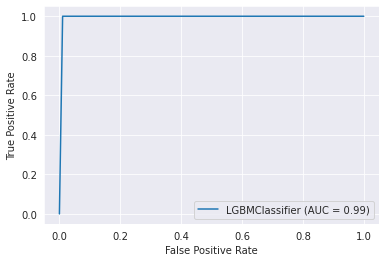

In [15]:
lgb_disp = plot_roc_curve(lgb, X_test, y_test)
plt.show()

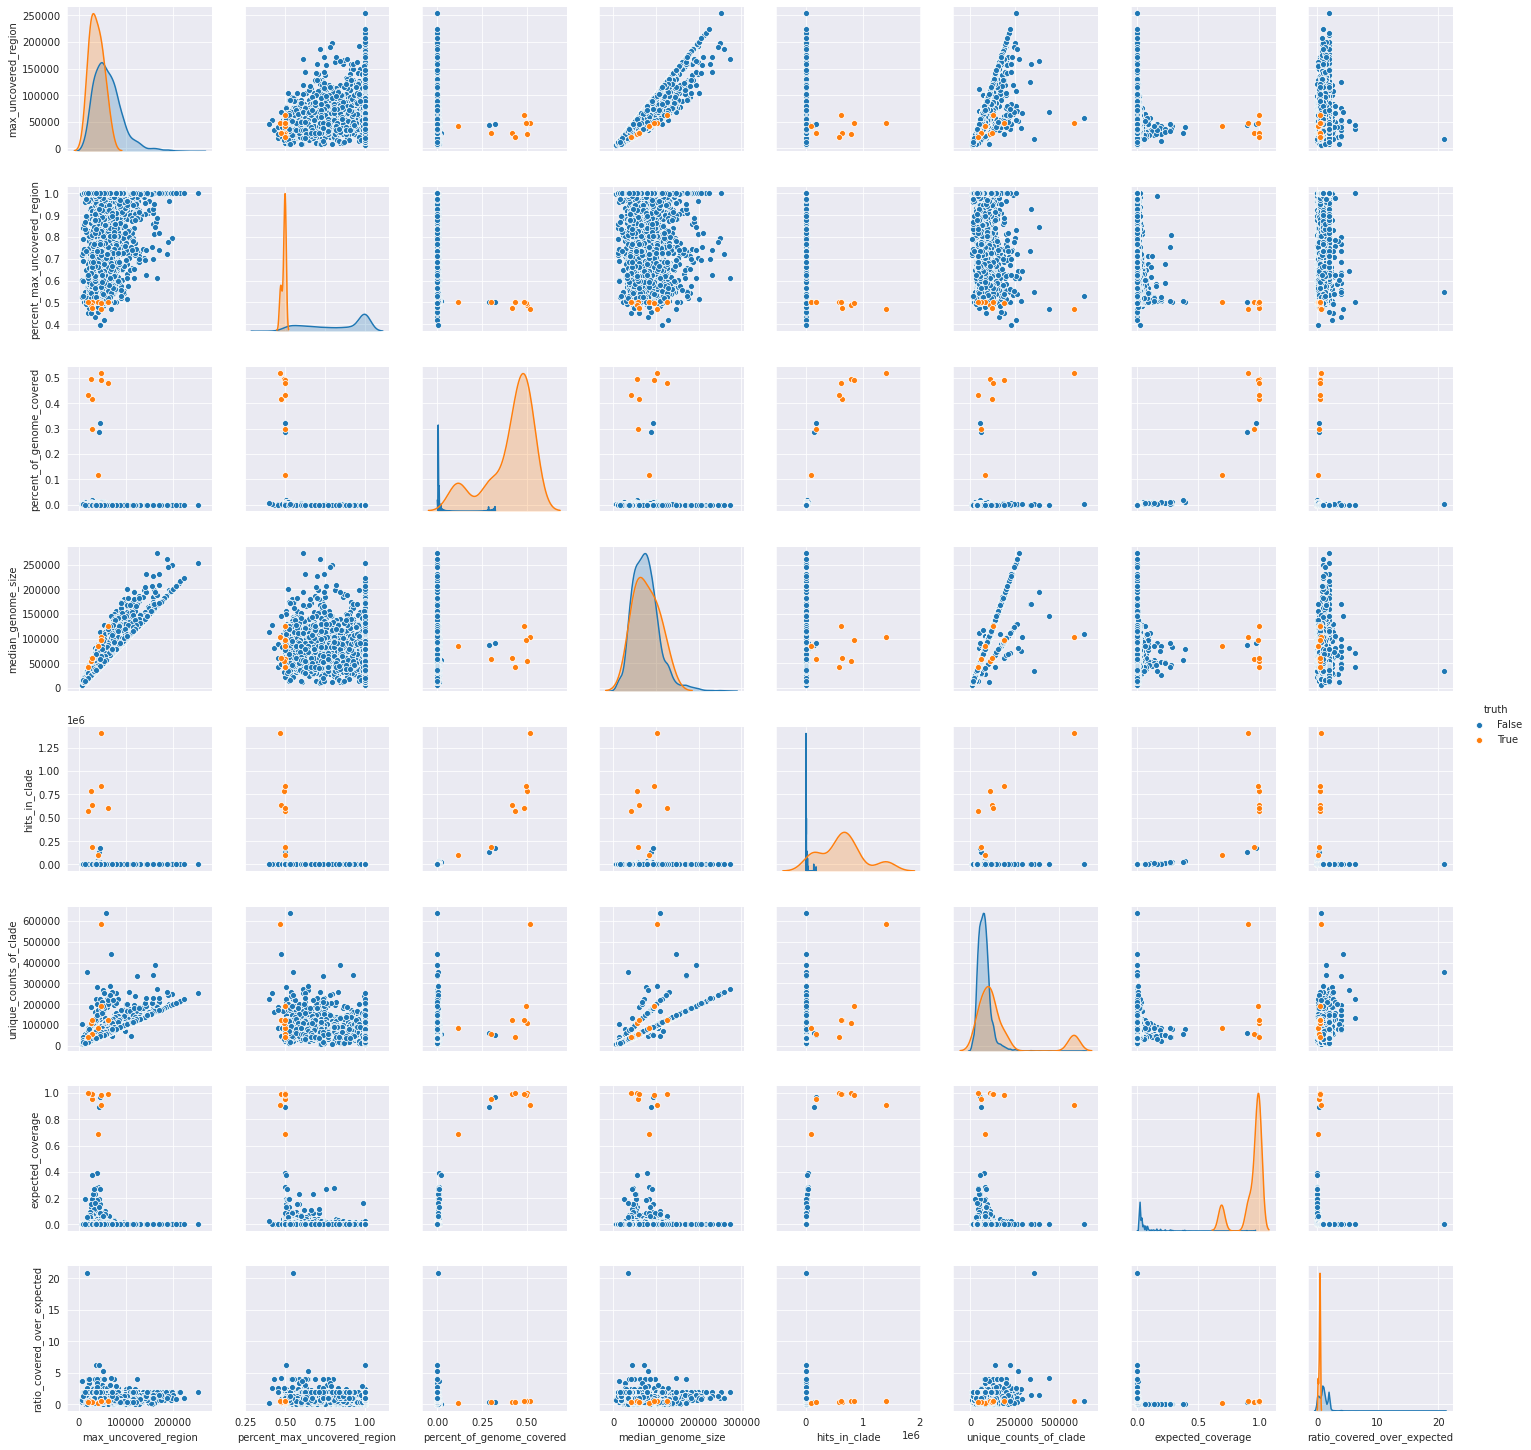

In [16]:
sns.pairplot(df_masked, hue="truth")

In [17]:
import joblib

In [18]:
rfc_hmp_mock = joblib.load("/mnt/nvidia/pkr/code/type_1/data/hmp_mock_community/shi7_learning_tminx/rfc.pkl")

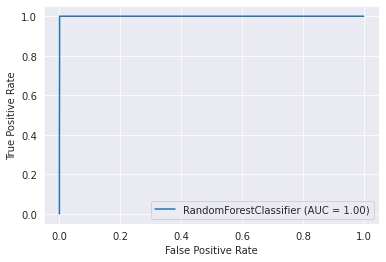

In [19]:
rfc_disp = plot_roc_curve(rfc_hmp_mock, X, y)

In [20]:
predictions = rfc_hmp_mock.predict_proba(X)

In [21]:
(predictions[:, 1] > .75).sum()

11

In [22]:
X[predictions[:, 1] > .75]

,expected_coverage,hits_in_clade,max_uncovered_region,median_genome_size,percent_max_uncovered_region,percent_of_genome_covered,ratio_covered_over_expected,unique_counts_of_clade
1116,0.69043,98037.0,42155.0,84312.0,0.49999,0.11606,0.16809,83608.0
1190,0.95721,183196.0,29447.0,58890.0,0.50003,0.29779,0.31110,58131.0
1193,0.37730,26442.0,28214.0,55952.0,0.50425,0.02002,0.05305,55821.0
1289,0.99931,787149.0,27096.0,55311.0,0.48988,0.49831,0.49865,108108.0
1356,0.99474,640998.0,29146.0,61328.0,0.47525,0.41854,0.42075,122134.0
1411,1.00000,575165.0,20985.0,41973.0,0.49996,0.43359,0.43359,41270.0
3265,0.91009,1405431.0,48355.0,103341.0,0.46792,0.51908,0.57036,583425.0
3279,0.98778,842826.0,48088.0,96664.0,0.49748,0.49408,0.50019,191332.0
3280,0.89673,137612.0,43690.0,87384.0,0.49998,0.28651,0.31950,60612.0
3281,0.96843,179785.0,46069.0,92142.0,0.49998,0.32414,0.33471,52027.0


In [23]:
for i in [.1, .2, .3, .4, .5, .6, .7, .8, .9]:
    print(y[predictions[:, 1] > i].sum() / (predictions[:, 1] > i).sum())
print(df_masked.loc[predictions[:, 1] > i, ["tax", "truth"]].values)

0.022222222222222223
0.025078369905956112
0.027210884353741496
0.030418250950570342
0.039603960396039604
0.42105263157894735
0.7272727272727273
0.8
0.8
[['k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus_subtilis'
  True]
 ['k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Listeriaceae;g__Listeria;s__Listeria_monocytogenes'
  True]
 ['k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus_aureus'
  True]
 ['k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus_faecalis'
  True]
 ['k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus_fermentum'
  True]
 ['k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia_coli'
  True]
 ['k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacter

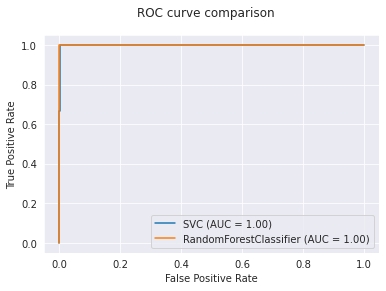

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

X = df_masked.loc[:, df_masked.columns.difference(["truth", "tax"])]
y = df_masked["truth"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

svc = SVC(random_state=42)
svc.fit(X_train, y_train)
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

svc_disp = plot_roc_curve(svc, X_test, y_test)
rfc_disp = plot_roc_curve(rfc, X_test, y_test, ax=svc_disp.ax_)
rfc_disp.figure_.suptitle("ROC curve comparison")

plt.show()